# M5 Forecasting Competition GluonTS Template

This notebook can be used as a starting point for participating in the [M5 uncertainty forecasting competition](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview) using GluonTS-based tooling.



### Standard imports

First we import standard data manipulation libraries.

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

!pip install gluonts

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


     |████████████████████████████████| 323 kB 2.7 MB/s 
     |████████████████████████████████| 7.5 MB 19.4 MB/s 
     |████████████████████████████████| 192 kB 48.1 MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68718 sha256=f8d22f1d99e7c531aab738ce6a83d86876d3ec72b30c511b6a99fe79ef98b971
  Stored in directory: /root/.cache/pip/wheels/e0/e6/69/fc449f332d998b63ede372a74a53bb953ff0ca6bb90da39fac
Successfully built ujson


We also define globally accessible variables, such as the prediction length and the input path for the M5 data. Note that `single_prediction_length` corresponds to the length of the validation/evaluation periods, while `submission_prediction_length` corresponds to the length of both these periods combined.

By default the notebook is configured to run in submission mode (`submission` will be `True`), which means that we use all of the data for training and predict new values for a total length of `submission_prediction_length` for which we don't have ground truth values available (performance can be assessed by submitting prediction results to Kaggle). In contrast, setting `submission` to `False` will instead use the last `single_prediction_length`-many values of our training set as validation points (and hence these values will not be used for training), which enables us to validate our model's performance offline.

In [2]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
m5_input_path="../input/m5-forecasting-uncertainty"
submission=True

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

### Reading the M5 data into GluonTS

First we need to convert the provided M5 data into a format that is readable by GluonTS. At this point we assume that the M5 data, which can be downloaded from Kaggle, is present under `m5_input_path`.

In [3]:
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sales_train_validation = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv')
sample_submission = pd.read_csv(f'{m5_input_path}/sample_submission.csv')
sell_prices = pd.read_csv(f'{m5_input_path}/sell_prices.csv')

We start the data convertion process by building dynamic features (features that change over time, just like the target values). Here, we are mainly interested in the event indicators `event_type_1` and `event_type_2`. We will mostly drop dynamic time features as GluonTS will automatically add some of these as part of many models' transformation chains.

In [4]:
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

test_cal_features = cal_features.values.T
if submission:
    train_cal_features = test_cal_features[:,:-submission_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-submission_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-submission_prediction_length]

test_cal_features_list_orig = [test_cal_features] * len(sales_train_validation)
train_cal_features_list_orig = [train_cal_features] * len(sales_train_validation)

We then go on to build static features (features which are constant and series-specific). Here, we make use of all categorical features that are provided to us as part of the M5 data.

In [5]:
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values + 1
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)
state_ids_dict = dict(zip(sales_train_validation["state_id"], sales_train_validation["state_id"].astype('category').cat.codes + 1))

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values + 1
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)
store_ids_dict = dict(zip(sales_train_validation["store_id"], sales_train_validation["store_id"].astype('category').cat.codes + 1))

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values + 1
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)
cat_ids_dict = dict(zip(sales_train_validation["cat_id"], sales_train_validation["cat_id"].astype('category').cat.codes + 1))

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values + 1
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)
dept_ids_dict = dict(zip(sales_train_validation["dept_id"], sales_train_validation["dept_id"].astype('category').cat.codes + 1))

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values + 1
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)
item_ids_dict = dict(zip(sales_train_validation["item_id"], sales_train_validation["item_id"].astype('category').cat.codes + 1))

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

stat_cat_orig = np.concatenate(stat_cat_list)
stat_cat_orig = stat_cat_orig.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un) + 1, len(dept_ids_un) + 1, len(cat_ids_un) + 1, len(store_ids_un) + 1, len(state_ids_un) + 1]

In contrast to the accuracy forecasting challenge, the uncertainty challenge does not only require us to forecast individual time series from the `sales_train_validation` dataset, but also aggregate series. Due to the hierarchical nature of the M5 dataset, different aggregation levels are possible. See the [M5 guidelines](https://mofc.unic.ac.cy/m5-competition/) for a description of the respective levels and number of series in each level. Since this process can take a while, we will save these aggregate values such that they can be simply read from disk at a later point.

In [6]:
import itertools

states = ["CA", "TX", "WI"]
states_alt = ["WI", "CA", "TX"]
stores = ["CA_1", "CA_2", "CA_3", "CA_4", "TX_1", "TX_2", "TX_3", "WI_1", "WI_2", "WI_3"]
categories = ["FOODS", "HOBBIES", "HOUSEHOLD"]
departments = ["FOODS_1", "FOODS_2", "FOODS_3", "HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_1", "HOUSEHOLD_2"]
departments_counts = {
    "FOODS_1": 219,
    "FOODS_2": 399,
    "FOODS_3": 827,
    "HOBBIES_1": 424,
    "HOBBIES_2": 149,
    "HOUSEHOLD_1": 541,
    "HOUSEHOLD_2": 516
}

def select_series(identifier="", item_id="", dept_id="", cat_id="", store_id="", state_id=""):
    return sales_train_validation[(sales_train_validation['id'].str.contains(identifier)) &
                                  (sales_train_validation['item_id'].str.contains(item_id)) &
                                  (sales_train_validation['dept_id'].str.contains(dept_id)) &
                                  (sales_train_validation['cat_id'].str.contains(cat_id)) &
                                  (sales_train_validation['store_id'].str.contains(store_id)) &
                                  (sales_train_validation['state_id'].str.contains(state_id))]

agg_series = np.empty((0,1913), int)
agg_cat = np.empty((0,5), int)

agg_series = np.append(agg_series, [select_series().iloc[:,6:].values.sum(axis=0)], axis=0)
agg_cat = np.append(agg_cat, [[0,0,0,0,0]], axis=0)

for state in tqdm(states):
    agg_series = np.append(agg_series, [select_series(identifier=state).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,0,0,state_ids_dict[state]]], axis=0)
    
for store in tqdm(stores):
    agg_series = np.append(agg_series, [select_series(identifier=store).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,0,store_ids_dict[store],0]], axis=0)

for category in tqdm(categories):
    agg_series = np.append(agg_series, [select_series(identifier=category).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[category],0,0]], axis=0)

for department in tqdm(departments):
    agg_series = np.append(agg_series, [select_series(identifier=department).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[department],0,0,0]], axis=0)
    
    
states_categories = list(itertools.product(states,categories))
for sc in tqdm(states_categories):
    agg_series = np.append(agg_series, [select_series(state_id=sc[0], cat_id=sc[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[sc[1]],0,state_ids_dict[sc[0]]]], axis=0)
    
states_departments = list(itertools.product(states,departments))
for sd in tqdm(states_departments):
    agg_series = np.append(agg_series, [select_series(state_id=sd[0], dept_id=sd[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[sd[1]],0,0,state_ids_dict[sd[0]]]], axis=0)
    
stores_categories = list(itertools.product(stores,categories))
for sc in tqdm(stores_categories):
    agg_series = np.append(agg_series, [select_series(store_id=sc[0], cat_id=sc[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[sc[1]],store_ids_dict[sc[0]],0]], axis=0)
    
stores_departments = list(itertools.product(stores,departments))
for sd in tqdm(stores_departments):
    agg_series = np.append(agg_series, [select_series(store_id=sd[0], dept_id=sd[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[sd[1]],0,store_ids_dict[sd[0]],0]], axis=0)
    
for department in tqdm(departments):
    for t_id in tqdm(range(1, departments_counts[department] + 1)):
        ident_str = f'{department}_{t_id:03}'
        series = select_series(item_id=ident_str).iloc[:,6:].values.sum(axis=0)
        if np.sum(series) > 0:
            agg_series = np.append(agg_series, [series], axis=0)
            agg_cat = np.append(agg_cat, [[item_ids_dict[ident_str],dept_ids_dict[department],0,0,0]], axis=0)
            
for state in tqdm(states_alt):
    for department in tqdm(departments):
        for t_id in tqdm(range(1, departments_counts[department] + 1)):
            ident_str = f'{department}_{t_id:03}'
            series = select_series(item_id=ident_str, state_id=state).iloc[:,6:].values.sum(axis=0)
            if np.sum(series) > 0:
                agg_series = np.append(agg_series, [series], axis=0)
                agg_cat = np.append(agg_cat, [[item_ids_dict[ident_str],dept_ids_dict[department],0,0,state_ids_dict[state]]], axis=0)
                
np.save(f'{m5_input_path}/aggregates.npy', agg_series) 
np.save(f'{m5_input_path}/aggregates_cat.npy', agg_cat)

Once we have calculated all aggreated series, we still need to ensure that both static and dynamic features are also available for these series and that the aggreagted and the original series are concatenated into the same array.

In [7]:
test_cal_features_list = [test_cal_features] * len(agg_series)
test_cal_features_list.extend(test_cal_features_list_orig)
train_cal_features_list = [train_cal_features] * len(agg_series)
train_cal_features_list.extend(train_cal_features_list_orig)

stat_cat = np.append(agg_cat, stat_cat_orig, axis=0)

train_df = sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
series_tot = np.append(agg_series, train_df.values, axis=0)

Finally, we can build both the training and the testing set from target values and both static and dynamic features.

In [8]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

if submission == True:
    train_target_values = [ts for ts in series_tot]
    test_target_values = [np.append(ts, np.ones(submission_prediction_length) * np.nan) for ts in series_tot]
else:
    test_target_values = series_tot.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in series_tot]
    
m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(train_target_values))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed contain the correct target values as well as dynamic and static features.

In [9]:
next(iter(train_ds))

{'target': array([32631., 31749., 23783., ..., 40517., 48962., 49795.], dtype=float32),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([0, 0, 0, 0, 0], dtype=int32),
 'source': SourceContext(source='list_data', row=1)}

In [10]:
next(iter(test_ds))

{'target': array([32631., 31749., 23783., ...,    nan,    nan,    nan], dtype=float32),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([0, 0, 0, 0, 0], dtype=int32),
 'source': SourceContext(source='list_data', row=1)}

### Define the estimator

Having obtained our training and testing data, we can now create a GluonTS estimator. In our example we will use the `DeepAREstimator`, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. In the M5 case, we think that the `NegativeBinomialOutput` distribution best describes the output.

For a full list of available estimators and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html.

For a full list of available output distributions and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.distribution.html.

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=200,
        batch_size=100
    )
)

predictor = estimator.train(train_ds)

  0%|          | 0/200 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 200/200 [01:40<00:00,  2.00it/s, avg_epoch_loss=0.935]


### Generating forecasts

Once the estimator is fully trained, we can generate predictions from it for the test values.

In [12]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

Obtaining time series conditioning values ...



Obtaining time series predictions ...


### Local performance validation (if `submission` is `False`)

Since we don't want to constantly submit our results to Kaggle, it is important to being able to evaluate performace on our own validation set offline. We can use a standard GluonTS evaluator to calculate the the mean weighte quantile loss (`mean_wQuantileLoss`) and lots of other metrics.

In [13]:
if submission == False:
    
    from gluonts.evaluation import Evaluator
    
    evaluator = Evaluator(quantiles=quantiles)
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

### Converting forecasts back to M5 submission format (if `submission` is `True`)

In order to come up with proper uncertainty estimates from our model, wen can directly evaluate the forecasts at multiple quantile levels.

In [14]:
if submission == True:
    def quantile_calc(q):
        res = np.ones((len(forecasts), prediction_length))
        for i, f in enumerate(forecasts):
            res[i] = f.quantile(q)
        return res

    allresults = list(map(quantile_calc, quantiles))
    allresults_conc = np.concatenate(allresults, axis=0)

Once we have obtained these predictions, we still need to reshape them to the correct submission format.

In [15]:
if submission == True:
    forecasts_acc_sub = np.zeros((len(allresults_conc)*2, single_prediction_length))
    forecasts_acc_sub[:len(allresults_conc)] = allresults_conc[:,:single_prediction_length]
    forecasts_acc_sub[len(allresults_conc):] = allresults_conc[:,single_prediction_length:]

Then, we save our submission into a timestamped CSV file which can subsequently be uploaded to Kaggle.

In [16]:
if submission == True:
    import time

    sample_submission = pd.read_csv(f'{m5_input_path}/sample_submission.csv')
    sample_submission.iloc[:,1:] = forecasts_acc_sub

    submission_id = 'submission_{}.csv'.format(int(time.time()))

    sample_submission.to_csv(submission_id, index=False)

### Plotting sample predictions

Finally, we can also visualize our predictions for some of the time series.

Plotting time series predictions ...


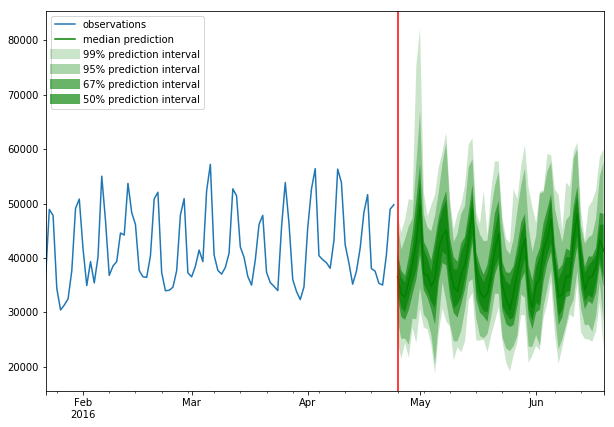

<Figure size 432x288 with 0 Axes>

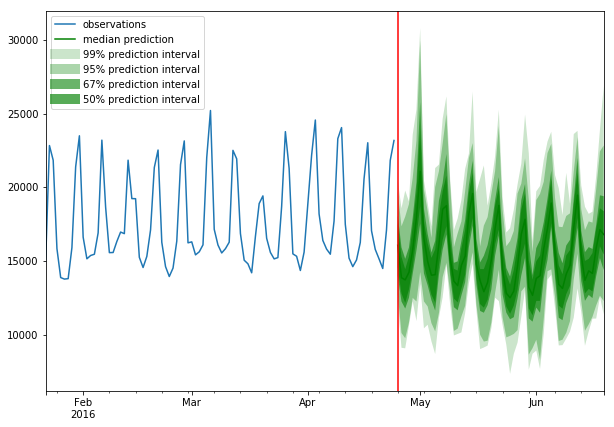

<Figure size 432x288 with 0 Axes>

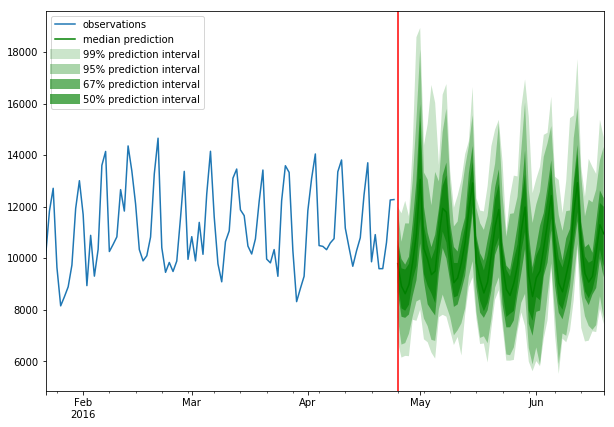

<Figure size 432x288 with 0 Axes>

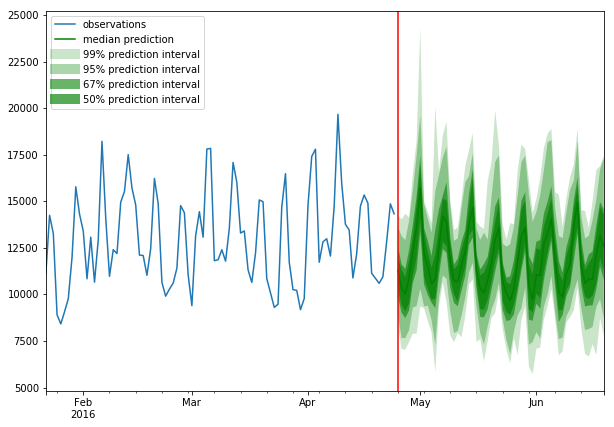

<Figure size 432x288 with 0 Axes>

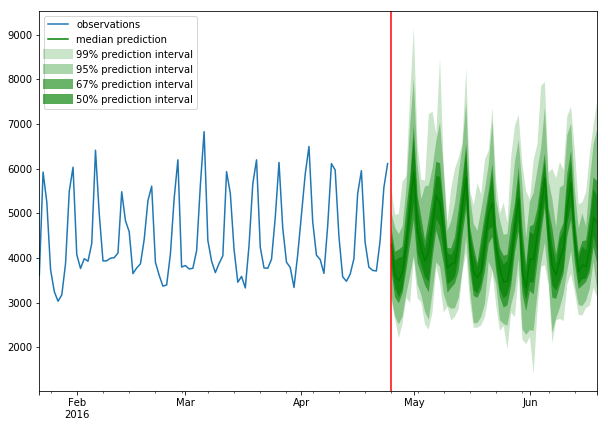

<Figure size 432x288 with 0 Axes>

In [17]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)